MACHINE LEARNING

In [1]:
!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel("Modeling.xlsx", engine='openpyxl')
df.head()

,Store ID,Pop class,Sales,Centre Type,Climate,Total Store Sq Ft,Sales Floor Sq Ft,Girls Sq Ft,Guys Sq Ft,Accessories Sq Ft,...,Poverty: In poverty,Male 14 to 35 CrYr,Female 14 to 35 CrYr,Total Pop 14 to 35 CrYr,Under 25 Low Income,Under 25 Med Income,Under 25 High Income,25 to 44 Low Income,25 to 44 Med Income,25 to 44 High Income
0,1,Suburban,1345251.88,Outlet,Frigid,4735.0,4015.6,2032.3,947.7,747.5,...,1680,4444,4095,8539,74,285,7,683,1692,1291
1,2,Urban,1669906.40,Mall,Moderate,8068.0,7128.6,2735.2,1788.1,1251.3,...,21003,58486,52872,111358,1317,1396,358,11104,21417,20357
2,3,Urban,2528042.74,Outlet,Hot,4583.2,3961.7,2082.9,1030.2,551.7,...,107701,286481,275998,562479,14977,11109,2870,63228,120359,99407
3,4,Suburban,1281613.45,Outlet,Moderate,5772.3,4713.0,2140.1,1149.0,1162.2,...,23477,45764,43429,89193,5135,2426,512,10011,15485,9238
4,5,Urban,1278092.87,Outlet,Cold,3503.0,3239.0,1870.6,769.5,483.5,...,65968,157166,152880,310046,11249,6220,2311,32448,57978,74382


In [4]:
df.isnull().sum() 

Store ID                           0
Pop class                          0
Sales                              0
Centre Type                        0
Climate                            0
Total Store Sq Ft                  0
Sales Floor Sq Ft                  0
Girls Sq Ft                        6
Guys Sq Ft                         5
Accessories Sq Ft                  6
Guys Segmentation                  0
Girls Segmentation                 0
ChangeMade                         0
ChangeDate                       412
Population Est CrYr                0
Transient Pop Est                  0
Seasonal Pop Est                   0
Sex Males CrYr                     0
Sex Females CrYr                   0
Age Average CrYr                   0
Unemployment Rate                  0
Average Household Income CrYr      0
Householder under 25 years:        0
Householder 25 to 44 years:        0
Family Inc: Aggregate Average      0
Per Capita Income CrYr             0
Wealth: Average Household          0
P

In [5]:
df = df.fillna(df.mean(numeric_only=True))

In [6]:
df.isnull().sum().sum()

412

In [7]:
X = df.drop(['Store ID', 'Sales'], axis=1)
y = df['Sales']

In [8]:
X = pd.get_dummies(X, drop_first=True)
X = X.astype({col: int for col in X.select_dtypes(include='bool').columns})
X = X.astype('float64')

In [9]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [11]:
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)


ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     4.013
Date:                Sun, 21 Sep 2025   Prob (F-statistic):           1.26e-29
Time:                        00:23:21   Log-Likelihood:                -7707.1
No. Observations:                 552   AIC:                         1.576e+04
Df Residuals:                     379   BIC:                         1.651e+04
Df Model:                         172                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [12]:
print(X.dtypes.value_counts())

float64    194
Name: count, dtype: int64


Key Drivers

In [13]:
significant_features = ols_model.pvalues[ols_model.pvalues < 0.05].index.tolist()
X_train_sig = X_train_sm[significant_features]
final_model = sm.OLS(y_train, X_train_sig).fit()
print(final_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              1546.
Date:                Sun, 21 Sep 2025   Prob (F-statistic):                        0.00
Time:                        00:23:21   Log-Likelihood:                         -7884.6
No. Observations:                 552   AIC:                                  1.578e+04
Df Residuals:                     546   BIC:                                  1.581e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

These features had p-value < 0.05:
1)Total Store Sq Ft
2)Transient Pop Est
3)Average Household Income CrYr
4)Centre Type_Outlet
5)Centre Type_Strip

Detecting Multicollinearity

In [14]:
X_vif=X_train_sig.drop(columns='const', errors='ignore')
vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_df.sort_values(by="VIF", ascending=False))


                         Feature         VIF
3         Per Capita Income CrYr  126.387017
2  Average Household Income CrYr  126.039498
0              Total Store Sq Ft   13.889183
5              Centre Type_Strip    1.657322
4             Centre Type_Outlet    1.492241
1              Transient Pop Est    1.478093


Residual Analysis

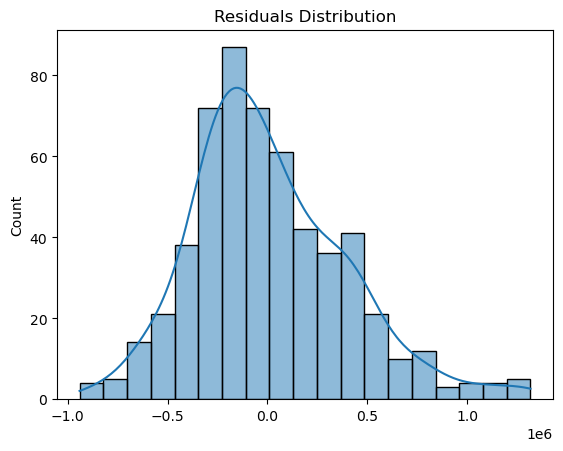

In [15]:
y_train_pred = final_model.predict(X_train_sig)
residuals = y_train - y_train_pred

sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()


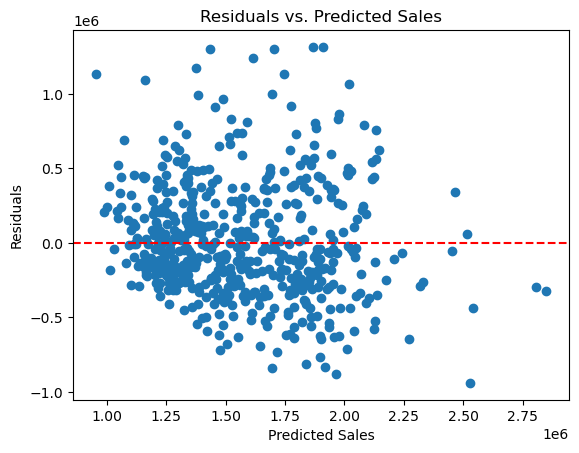

In [16]:
plt.scatter(y_train_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Sales")
plt.show()

In [17]:
print(df.columns.tolist())

['Store ID', 'Pop class', 'Sales', 'Centre Type', 'Climate', 'Total Store Sq Ft', 'Sales Floor Sq Ft', 'Girls Sq Ft', 'Guys Sq Ft', 'Accessories Sq Ft', 'Guys Segmentation', 'Girls Segmentation', 'ChangeMade', 'ChangeDate', 'Population Est CrYr', 'Transient Pop Est', 'Seasonal Pop Est', 'Sex Males CrYr', 'Sex Females CrYr', 'Age Average CrYr', 'Unemployment Rate', 'Average Household Income CrYr', 'Householder under 25 years:', 'Householder 25 to 44 years:', 'Family Inc: Aggregate Average', 'Per Capita Income CrYr', 'Wealth: Average Household', 'Poverty: In poverty', 'Male 14 to 35 CrYr', 'Female 14 to 35 CrYr', 'Total Pop 14 to 35 CrYr', 'Under 25 Low Income', 'Under 25 Med Income', 'Under 25 High Income', '25 to 44 Low Income', '25 to 44 Med Income', '25 to 44 High Income']


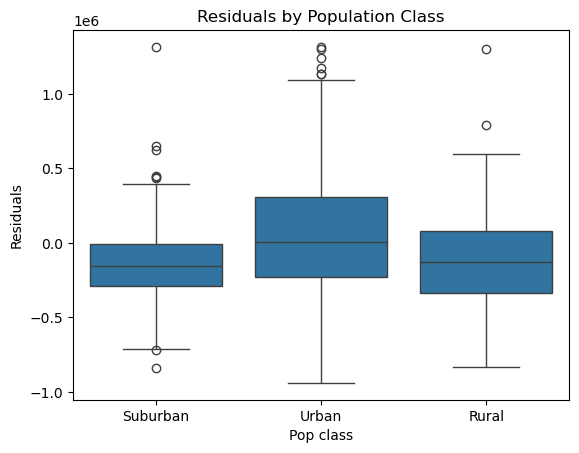

In [18]:
residual_df = df[['Store ID', 'Pop class', 'Centre Type']].copy()
residual_df['Residuals'] = y_train - final_model.predict(X_train_sig)
sns.boxplot(x='Pop class', y='Residuals', data=residual_df)
plt.title("Residuals by Population Class")
plt.show()
